# Multi-Layer Perceptron Regression

In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *

import torch
from torch.utils.data import DataLoader, TensorDataset
from models import MLPRegressor, RMLPRegressor, PMLPRegressor, RPMLPRegressor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(to_tensor(load_data(datadir), device))

In [3]:
train_X = data.train.embeddings
validation_X = data.validation.embeddings
test_X = data.test.embeddings

In [4]:
train_Var = data.train.y_err ** 2
validation_Var = data.validation.y_err ** 2

In [5]:
train_Y = data.train.y
validation_Y = data.validation.y
test_Y = data.test.y

In [11]:
dataset = GaussianSamplingDataset(train_X, train_Y, train_Var)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## MLP Model

In [12]:
model = RMLPRegressor(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=512, dropout=0.4
).to(device)

## Train

  7%|██▉                                      | 72/1024 [00:16<03:32,  4.47it/s]


Val.: 0.0573
Test: 0.0607
[ 0.13207081 -0.00307853  0.08676663 -0.00355826  0.04747613  0.00986409
  0.1552713 ]


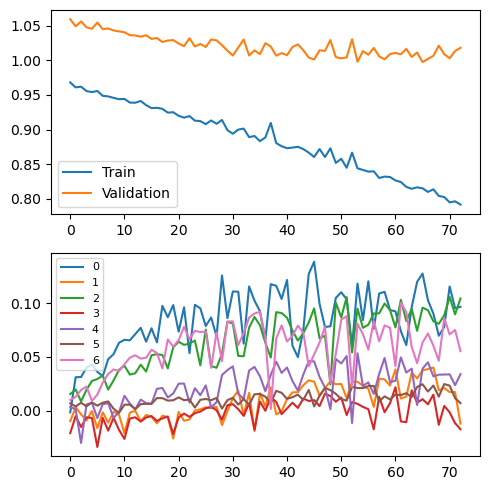

In [13]:
validation_score = model.fit(
    train_X=train_X, train_Y=train_Y, train_Var=train_Var, 
    validation_X=validation_X, validation_Y=validation_Y, validation_Var=validation_Var, 
    dataloader=dataloader, 
    lr=0.0001, epochs=1024, patience=0.002, 
    early_stopping=True, plot=True, show_progress=True
)
test_score = model.score(test_X, test_Y)

print(f'Val.: {validation_score:.4f}')
print(f'Test: {test_score:.4f}')
print(model.score(test_X, test_Y, multioutput=None))

## Visualization

In [14]:
x, y_true = test_X, test_Y

In [16]:
y_pred = model(x).detach()

In [17]:
scores = r2_score(y_true.cpu(), y_pred.cpu(), multioutput='raw_values')
print(scores)

[ 0.13207081 -0.00307853  0.08676663 -0.00355826  0.04747613  0.00986409
  0.1552713 ]


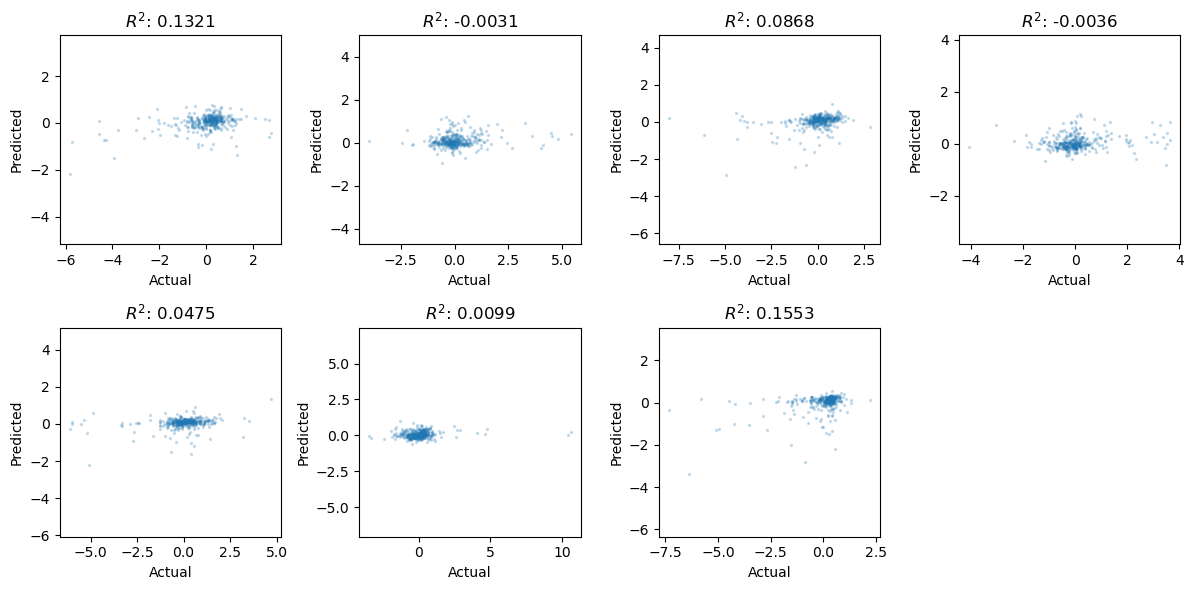

In [19]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
while (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if y_pred.shape[1] == 1 else axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i].cpu(), y_pred[:, i].cpu(), s=2, alpha=0.2)
    #ax.errorbar(
    #    y_true[:, i].cpu(), y_pred[:, i].cpu(), y_pred_std[:, i].cpu(), 
    #    fmt='.', markersize=2, alpha=0.2
    #)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'$R^2$: {scores[i]:.4f}')
    ax.set_aspect('equal', adjustable='datalim')

axs[-1].axis('off')

plt.tight_layout()